In [2]:
import pandas as pd
import re
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 322
!pip freeze > requirements.txt

#импортировали исходные данные
df = pd.read_csv('main_task.csv')
df_kaggle = pd.read_csv('kaggle_task.csv')
sample_sumbission = pd.read_csv('sample_submission.csv')
df['sample'] = 1 # помечаем где у нас трейн
df_kaggle['sample'] = 0 # помечаем где у нас тест
df_kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_kaggle.append(df, sort=False).reset_index(drop=True) # объединяем

df = data
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0


In [3]:
# смотрим что в sample
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


# Функции

In [61]:
#функции обработки

#считаем % пропусков по каждому признаку
#функция missing_data(data) будет принимать на вход датасет, и определять % пропусков и тип данных
def missing_data(data):
    for i in data.columns:
        md = 100-data[i].isna().value_counts()[0]*100/len(data[i])
        print('% пропусков в',i, md)
    return

#функция конвертации строковых данных в столбце Price Range, на фход идет серия, на выходе числовые значения 
#ghbpyfrf ценовой категории
def price_cat(data):
    if data == '$':
        return 1
    elif data == '$$ - $$$':
        return 2
    elif data == '$$$$':
        return 3

#функция которая получает на вход серию со списком всех кухонь и убирает аартефакты в названиях,
#формируя список 
def resplit(ct):
    ct = ct.replace(", ",'')
    ct = ct.replace("[",'')
    ct = ct.replace("]",'')
    ct = re.split("'(.*?)'",ct)
    ct = list(filter(None, ct))
    return ct

#функция разбивки типов кухонь , нужная для выполенния заданий в модуле
def split_cuisine(ct):
    if re.findall(r"'(.*?)'", ct) == 'Unknown':
        return 'Unknown'
    else:
        return  re.findall(r"'(.*?)'", ct)

#простая функция длинны списка
def len_list(data):
    return len(data)


# функиця разделения даты из отзывов
# тип данных строка, визуально похожая на списки
# необходимо разпарсить данные
# кроме того , в строке есть дата отзыва, ее тоже надо достать
# кол-во дат будет равно кол-ву отзывов

def split_date(ct):
    if re.findall(r'\d\d/\d\d/\d{4}', ct) == 'None':
        return dt.datetime(1900,12,31)
    else:
        return  re.findall(r'\d\d/\d\d/\d{4}', ct)
    
# функция возвращает разницу между первым и последним отзывом в формате datetime
def deltadays(rd):
    if len(rd)>=2:
        a = dt.datetime.strptime(rd[0], '%m/%d/%Y') - dt.datetime.strptime(rd[len(rd)-1], '%m/%d/%Y')
        return a
    else:
        return dt.timedelta(0)

def learn_fit(df, random_state = None):
    #X - данные о ресторанах, Y - целевая переменная

    X = df.drop(['Rating', 'Restaurant_id'], axis = 1)
    y = df['Rating']
    
    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
    #создаем модель
    regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
    #обучение на тесте
    regr.fit(X_train, y_train)
    
    #используем полученную (обученную модель) для предсказания рейтинга в тестовой сборке
    #полученное значение пишем в отдульную переменную
    y_predict = regr.predict(X_test)
    
    #сравниваем предсказанное значение y_predict с тестовым y_test
    print('MAE Regression:', metrics.mean_absolute_error(y_test,y_predict))
    print('MAE Regression round state:', metrics.mean_absolute_error(y_test,np.round(y_predict*2)/2))
    
    #классификация
    le = LabelEncoder()
    le.fit(y_train)
    classif = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_SEED, n_jobs=-1)
    classif.fit(X_train, le.transform(y_train))
    y_predict = classif.predict(X_test)
    print('MAE Классификация:', metrics.mean_absolute_error(y_test,le.inverse_transform(y_predict)))
    
#    plt.rcParams['figure.figsize'] = (10,10)
#    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
#    feat_importances.nlargest(15).plot(kind='barh')

# Определим кол-во пропусков в признаках. В нашей задаче пропуски надо либо заполнить либо исключить

In [5]:
missing_data(df)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 34.721999999999994
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0


# Видим что есть пропуски в признаках типа кухонь "Cuisine Style" , "Price Range", и "Number of Reviews"

In [6]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

# Посмотрим что покажет модель при базовых данных, для этого будем использовать функцию в которой записан ML, это удобно при дальнейшей процедуре Feature Engeneering

так мы будем проверять каждый раз влияние на результат введенного признака либо очистку данных

In [7]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.34551783170533173
MAE Regression round state: 0.3338034188034188
MAE Классификация: 0.3828632478632479


In [8]:
#посмотрим как меняется рейтинг по городам 

df.groupby('City').Rating.agg(['mean','std','count']).sort_values(by=['mean'], ascending=False)

,mean,std,count
City,,,
Athens,3.423325,1.734354,776
Rome,3.395326,1.730001,2589
Ljubljana,3.389640,1.664843,222
Oporto,3.338785,1.757784,642
Krakow,3.315884,1.756785,554
Vienna,3.295218,1.703231,1443
Berlin,3.285952,1.757230,2705
Edinburgh,3.270470,1.743363,745
Amsterdam,3.270044,1.753022,1372


# feature engineering

In [56]:
#создание новых признаков и заполнение пропусков

## обработаем города и создадим новые признаки

### признак Столица - capital

In [9]:
#признак Столица - capital

#импортируем данные по городам мира, и заберем оттуда только столицы (признак primary)
cities = pd.read_csv('worldcities.csv') #публичный датасет по городам мира
cities = cities[cities['capital']=='primary']

#уберем ненужную информацию и сформируем список столиц мира, хотя нам надо только европу, но все же
cities.drop(['city_ascii', 'lat','lng','capital','id','admin_name'], inplace=True, axis=1)
cities_list=list(cities['city'])

#вводим новый признак Столица, 1 если город столичный, 0 если не столичный
df['capital']=df['City'].apply(lambda x: 1 if x in cities_list else 0 )

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с мотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.323343432030932
MAE Regression round state: 0.31017094017094016
MAE Классификация: 0.35341880341880344


### признак население - population

In [11]:


#получаем список уникальных городов
city_list=df['City'].unique()

#попробуем добавить численность населения
city_list={'Paris':2.148, 'Stockholm':0.975, 'London':8.961, 'Berlin':3.669, 'Munich':1.488, 'Oporto':0.287,
       'Milan':1.1399, 'Bratislava':0.428, 'Vienna':1.921, 'Rome':2.790, 'Barcelona':1.664, 'Madrid':3.334,
       'Dublin':1.173, 'Brussels':1.212, 'Zurich':0.434, 'Warsaw':1.793, 'Budapest':1.750, 'Copenhagen':0.794,
       'Amsterdam':0.860, 'Lyon':0.518, 'Hamburg':1.845, 'Lisbon':0.506, 'Prague':1.335, 'Oslo':0.693,
       'Helsinki':0.655, 'Edinburgh':0.488, 'Geneva':0.201, 'Ljubljana':0.286, 'Athens':0.664,
       'Luxembourg':0.644, 'Krakow':0.779}
df['population'] = df.City.replace(to_replace=city_list)


In [12]:
#проверяем модель

In [13]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт мотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18134871794871793
MAE Regression round state: 0.16042735042735043
MAE Классификация: 0.18012820512820513


In [13]:
#Отлично!!! модель улучшена почти в 2 раза, играем дальше


### приведем категориальную переменную Price Range к числовому виду и заменим пропуски модальным значением

In [14]:
#узнаем модальное значение для категории Price Range
#rjnjhsv позже заполним пропуски
print('Модальное значение для категории Price Range',df['Price Range'].mode()[0])



range_replace={'$':1, '$$ - $$$':2, '$$$$':3}

df['Price Range']=df['Price Range'].replace(to_replace=range_replace)

#заменим пропуски модальным значением
df['Price Range'].fillna(2, inplace=True, axis=0)

#делаем тоже самое с кэгл
#df_kaggle['Price Range']=df_kaggle['Price Range'].replace(to_replace=range_replace)
#df_kaggle['Price Range'].fillna(2, inplace=True, axis=0)

#проверяем пропуски
missing_data(df)

#проверяем модель , уже не удаляем столбец Price Range т.к. мы его изменили 
drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Модальное значение для категории Price Range $$ - $$$
% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18066965811965813
MAE Regression round state: 0.16004273504273503
MAE Классификация: 0.1838034188034188


In [15]:
#есть  небольшое улучшение 


### Добавим признак цены в городе

In [15]:

price_in_city_dict = df.groupby('City')['Price Range'].mean().to_dict()
df['Price in City'] = df['City'].map(price_in_city_dict)


In [16]:
#опять проверяем модель

drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.17832008547008546
MAE Regression round state: 0.1579059829059829
MAE Классификация: 0.17884615384615385


### Попробуем поиграть с кухнями

In [18]:
#добавили количество кухонь в ресторане? это данные внешнего парсинга сайта tripadvisor
#т.к. scraping занимает много времени, его провели отдельным проектом, а здесь только импортируем результаты
#что бы сократить время

cuisine = pd.read_csv('cuisine.csv')

#missing_data(cuisine)
#видим что удалось убрать пропуски в признаке Cuisine Style
#теперь заменим данные на данные парсинга и сразу посчитаем кол-во кухонь в ресторане создав новый признак

#применяем функцию которая создает списки кухонь в признаке без артефактов в строковых значениймх
df['Cuisine Style'] = cuisine['Cuisine Style'].apply(resplit)

### признак col-cuisine - кол-во кухонь в ресторане

In [19]:
#считаем кол-во кухонь в каждом ресторане
df['col_cuisine'] = df['Cuisine Style'].apply(len)

#проверим результат добавления нового признака
#drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

#видим что есть улучшение, оставляем признак col_cuisine

#посчиатем сколько уникальных кухонь есть в принципе

unique_cuisine = df['Cuisine Style'].explode().unique()
unique_cuisine


array(['Bar', 'Pub', 'European', 'Scandinavian', 'Gluten Free Options',
       'Vegetarian Friendly', 'Vegan Options', 'Italian', 'Mediterranean',
       'Seafood', 'French', 'Cafe', 'Fast Food', 'Portuguese', nan,
       'Greek', 'Friendly', 'Czech', 'Eastern European',
       'Central European', 'Pizza', 'British', 'Spanish', 'Norwegian',
       'African', 'Moroccan', 'Middle Eastern', 'Halal', 'Indian', 'Thai',
       'Dutch', 'Welsh', 'American', 'Steakhouse', 'Soups', 'Scottish',
       'Fusion', 'Street Food', 'Hungarian', 'Asian', 'Wine Bar',
       'Barbecue', 'Central American', 'Deli', 'Peruvian',
       'South American', 'Irish', 'Polish', 'Vietnamese', 'Lebanese',
       'Turkish', 'Healthy', 'Japanese', 'Sushi', 'Austrian', 'Chinese',
       'Danish', 'International', 'Gastropub', 'Korean', 'German',
       'Contemporary', 'Food', 'Arabic', 'Diner', 'Swiss', 'Swedish',
       'Persian', 'Dessert', 'Eastern', 'Options', 'Australian', 'Grill',
       'Mexican', 'Bites', 'Lat

### добавим признак соотношения кол-ва кухонь в ресторане к макс кол-ву кухонь в городе

In [20]:
dict = pd.DataFrame(df.groupby('City')['Cuisine Style'].agg('sum'))
#display(dict)
dict['city_col_cuisine']=0

#импортируем нужные библиотеки для подсчета уникальных элементов в списке
from  more_itertools import unique_everseen

#считаем кол-во уникальных кухонь в каждом городе

for i in range(0,len(dict)):
    dict['city_col_cuisine'][i]=len(list(unique_everseen(dict['Cuisine Style'][i])))

dict_a = pd.DataFrame()

for i in range(0,len(dict)):
    new_row = {'city':dict.index[i], 'city_col_cuisine':dict.values[i][1]} 
    dict_a = dict_a.append(new_row, ignore_index=True)

new_dict = dict_a.set_index('city').T.to_dict('list')

<ipython-input-20-d8c7b4e4f2c3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict['city_col_cuisine'][i]=len(list(unique_everseen(dict['Cuisine Style'][i])))


### Добавим новый признак 'city_col_cuisine' - кол-во уникальных куонь в каждом городе

In [22]:
df['city_col_cuisine'] = df['City'].replace(to_replace=new_dict)


### Добавим новый признак, нормировка кухонь относительно каждого города

In [23]:

df['cuisine_norm']=df['col_cuisine']/df['city_col_cuisine']

#проверяем модель
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт новых признаков\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт новых признаков

MAE Regression: 0.1770136752136752
MAE Regression round state: 0.15376068376068375
MAE Классификация: 0.17756410256410257


In [24]:
#есть небольшое улучшение 


### создадим признак, кол-во ресторанов в городе

In [25]:

per_city_dict = df['City'].value_counts().to_dict()
per_city_dict
df['city_restaurants'] = df.City.map(per_city_dict)



### Добавим признак - нормализованный ранг ranking_norm

In [ ]:

df['ranking_norm'] = df.Ranking / df.city_restaurants

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)


In [22]:
#отношение кол-ва кухонь в ресторане к среднему кол-ву кухонь в этом городе

# !!!! - данный признак привел к ухудшению оценки, поэтому все закооментировано
# что бы в дальнейшем не было мыслей считать похожие признаки

#mean_city_cuisine = df.groupby('City')['col_cuisine'].mean().to_dict()
#mean_city_cuisine

#df['mcc'] = df.City.replace(to_replace=mean_city_cuisine)
#df['mcc_norm_by_city']=df['col_cuisine']/df['mcc']
#
#drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
#print('Смотрим на предикт с новым признаком\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [26]:
missing_data(df)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0


In [ ]:
#остались пропуски в Number of reviews

### Добавим новый признак nor - среднее кол-во ресторанов в городе

In [27]:
nor  = df.groupby('City')['Number of Reviews'].mean().to_dict()
nor

#добавили новый признак nor - среднее кол-во отзывов по городу
df['nor']=df['City'].replace(to_replace=nor)

#проверяем модель
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)


Смотрим на предикт с новыми признаками

MAE Regression: 0.17603760683760683
MAE Regression round state: 0.15508547008547008
MAE Классификация: 0.17867521367521366


In [24]:
#df.drop(['Number of Reviews'],  inplace=True, axis =1 )

### Будем использовать данные внешнего скрапинга данных что бы убрать пропуски в Number of Reviews

 код приведен ниже, что бы не тратить время на повторный сбор пропущенных данных
 использовались регулярные выражения 2х паттернов для отбора нужной информации

In [28]:
#import requests
#from bs4 import BeautifulSoup
#import re
#import math
#import time
#
#df_pars = df[['Restaurant_id','City','URL_TA','Number of Reviews']]

#df_pars['nor'] = df_pars['Number of Reviews']

#for i in range(len(df_pars['Number of Reviews'])-1,0,-1):
#    if pd.isnull(df_pars['Number of Reviews'][i]) == True:
#        #контроль
#        print(i,'проверка',df_pars['Number of Reviews'][i])
#        url = 'https://www.tripadvisor.com' + df_pars['URL_TA'][i]
#        headers = {
#        'User-Agent': 'My User Agent 1.0',
#        'From': 'personal@domain.com'  # This is another valid field
#        }
#        response = requests.get(url, headers=headers)
#        soup = BeautifulSoup(response.text, 'lxml')
#        pattern = re.compile(r'"reviewCount":"\d*"')
#        pattern2 = re.compile(r'\d*')
#        rc = re.findall(pattern, str(soup))
#       
#        if isinstance(rc, str) == True:
#            print('проверка ',rc, type(rc))
#            df_pars['Number of Reviews'][i] = re.findall(pattern2,rc[0])
#        else:
#            df_pars['Number of Reviews'][i] = 0
#    if i == 20000:
#        print('Пауза 5 минут',i)
#        time.sleep(300)
#    if i % 1000 == 0:
#        print('прошли тысячу строк',i)
#df_pars.to_csv('df_pars.csv')

In [29]:
#dblbv что есть пропуски в Number of Revies
#заменим  их данными парсинга
df_pars = pd.read_csv('df_pars.csv')

#проверяем что бы не было пропусков
missing_data(df_pars)

% пропусков в Unnamed: 0 0.0
% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в URL_TA 0.0
% пропусков в Number of Reviews 0.0


In [30]:
#заменим данные в признаке на данные полученные с сайта
df['Number of Reviews']=df_pars['Number of Reviews']

In [31]:
#делаем бэкап на всякий случай
backup = df

In [29]:
#tot одна проверка на пропуски
missing_data(df)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 0.0
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0
% пропусков в nor 0.0


<AxesSubplot:>

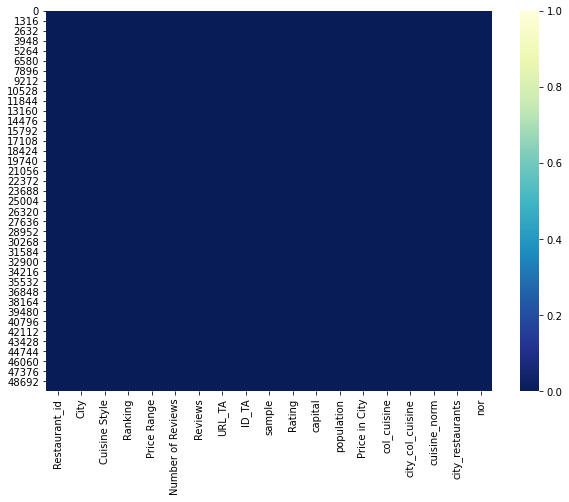

In [33]:
plt.figure(figsize=(10, 7))# размер тепловой карты
sns.heatmap(df.isnull(), cmap="YlGnBu_r")

In [34]:
#пропусков нет

In [35]:
#проверка MAE
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с новыми признаками

MAE Regression: 0.17126560000000002
MAE Regression round state: 0.1494
MAE Классификация: 0.17508


In [36]:
# Отличный результат, мы улучшили показатели добавиви дамми переменные по типу уникальных кухонь

#делаем dummy
backup = df
style = df['Cuisine Style'].explode()
X = pd.get_dummies(style)
index_list = pd.Index.tolist(X.index)
Y = X.groupby(index_list).sum()
df = df.join(Y)
style.unique()


array(['Bar', 'Pub', 'European', 'Scandinavian', 'Gluten Free Options',
       'Vegetarian Friendly', 'Vegan Options', 'Italian', 'Mediterranean',
       'Seafood', 'French', 'Cafe', 'Fast Food', 'Portuguese', nan,
       'Greek', 'Friendly', 'Czech', 'Eastern European',
       'Central European', 'Pizza', 'British', 'Spanish', 'Norwegian',
       'African', 'Moroccan', 'Middle Eastern', 'Halal', 'Indian', 'Thai',
       'Dutch', 'Welsh', 'American', 'Steakhouse', 'Soups', 'Scottish',
       'Fusion', 'Street Food', 'Hungarian', 'Asian', 'Wine Bar',
       'Barbecue', 'Central American', 'Deli', 'Peruvian',
       'South American', 'Irish', 'Polish', 'Vietnamese', 'Lebanese',
       'Turkish', 'Healthy', 'Japanese', 'Sushi', 'Austrian', 'Chinese',
       'Danish', 'International', 'Gastropub', 'Korean', 'German',
       'Contemporary', 'Food', 'Arabic', 'Diner', 'Swiss', 'Swedish',
       'Persian', 'Dessert', 'Eastern', 'Options', 'Australian', 'Grill',
       'Mexican', 'Bites', 'Lat

In [37]:
missing_data(df)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 0.0
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в nor 0.0
% пропусков в Afghani 0.0
% пропусков в African 0.0
% пропусков в Albanian 0.0
% пропусков в American 0.0
% пропусков в Arabic 0.0
% пропусков в Argentinean 0.0
% пропусков в Armenian 0.0
% пропусков в Asian 0.0
% пропусков в Australian 0.0
% пропусков в Austrian 0.0
% пропусков в Azerbaijani 0.0
% пропусков в Bakeries 0.0
% пропусков в Balti 0.0
% пропусков в Bangladeshi 0.0
% пропусков в Bar 0.0
% пропусков в Barbecue 0.0
% пропуско

In [40]:
backup_dummy=df




In [42]:
#добавим новый признак 

from sklearn.preprocessing import LabelEncoder
#City encoding
le = LabelEncoder()
le.fit(df.City)
df['city_le']=le.transform(df.City)

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с новыми признаками

MAE Regression: 0.16775959999999998
MAE Regression round state: 0.1444
MAE Классификация: 0.21416


<AxesSubplot:>

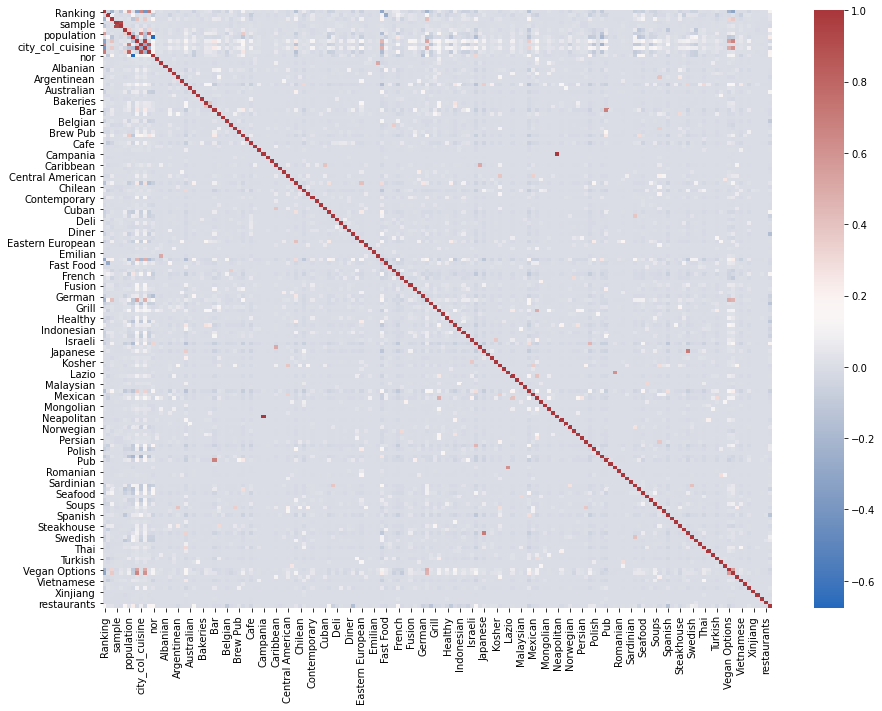

In [45]:
import seaborn as sns 
plt.rcParams['figure.figsize'] = (15,11)
sns.heatmap(df.corr(), cmap='vlag')

In [43]:
# Видим что набор дамми пеерменных дает широту разброса корреляции, но вся основная часть сосредоточена вврху слева)

#делаем бэкап перед созданием нового признака
#backup = df


<H1>Data Preprocessing</H1>

In [47]:
df_preproc = df

df_preproc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 170 entries, Restaurant_id to city_le
dtypes: float64(9), int32(1), int64(4), object(6), uint8(150)
memory usage: 14.6+ MB


In [48]:

missing_data(df)
df_preproc.drop(['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA'], axis = 1, inplace = True)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 0.0
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в nor 0.0
% пропусков в Afghani 0.0
% пропусков в African 0.0
% пропусков в Albanian 0.0
% пропусков в American 0.0
% пропусков в Arabic 0.0
% пропусков в Argentinean 0.0
% пропусков в Armenian 0.0
% пропусков в Asian 0.0
% пропусков в Australian 0.0
% пропусков в Austrian 0.0
% пропусков в Azerbaijani 0.0
% пропусков в Bakeries 0.0
% пропусков в Balti 0.0
% пропусков в Bangladeshi 0.0
% пропусков в Bar 0.0
% пропусков в Barbecue 0.0
% пропуско

In [49]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)


In [50]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [51]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape, y_train.shape

((10000, 163),
 (40000, 163),
 (40000, 162),
 (30000, 162),
 (10000, 162),
 (30000,))

<H1>ML</H1>

In [63]:


# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


y_pred = (y_pred * 2).round()/2


# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))






[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s


MAE: 0.1844


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [64]:
test_data = test_data.drop(['Rating'], axis=1)


In [65]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [52]:
#drop_columns = ['City', 'Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(test_data.drop(columns = drop_columns).dropna(), random_state=322)
#test_data

In [79]:
predict_submission = model.predict(test_data)
predict_submission = (predict_submission * 2).round()/2
predict_submission

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([3. , 4. , 4.5, ..., 3. , 4. , 4.5])

In [80]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
